In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

DATA_DIR = Path.cwd() / 'data'
OUTPUT_DIR = Path.cwd() / 'output'

def printUnique(df, col=None):
    if col is None:
        print(f"total index: {df.index.size}")
        print(f"unique index: {df.index.unique().size}")
    else:
        print(f"total {col}: {df[col].size}")
        print(f"unique {col}: {df[col].unique().size}")

In [2]:
"""
ADNI Patient Diagnosis
"""
df = pd.read_csv(DATA_DIR / 'DXSUM_PDXCONV_14Jun2024.csv')

# Patient diagnoses
# 1=Cognitively Normal; 2=Early MCI; 3=Late MCI; 4=Alzheimer's Disease; 5=Significant Memory Concern;
df_diag = df[['PHASE', 'PTID', 'EXAMDATE', 'DIAGNOSIS', 'DXAD']].dropna()
df_diag['DXAD'].replace({-4: 0}, inplace=True)
df_diag = df_diag.drop(df_diag[df_diag['DIAGNOSIS']==1].index)

printUnique(df_diag, 'PTID')
df_diag

total PTID: 2738
unique PTID: 610


,PHASE,PTID,EXAMDATE,DIAGNOSIS,DXAD
1,ADNI1,011_S_0003,2005-09-30,3.0,1.0
4,ADNI1,022_S_0007,2005-10-06,3.0,1.0
6,ADNI1,023_S_0030,2005-10-20,2.0,0.0
13,ADNI1,023_S_0042,2005-11-10,2.0,0.0
14,ADNI1,067_S_0029,2005-11-11,3.0,1.0
...,...,...,...,...,...
3861,ADNI1,082_S_1079,2008-12-01,3.0,1.0
3862,ADNI1,082_S_0832,2008-10-30,3.0,1.0
3863,ADNI1,082_S_0641,2008-03-17,3.0,1.0
3864,ADNI1,082_S_0641,2008-10-09,3.0,1.0


In [3]:
# Get unique patient IDs (PTIDs)
PTID_unique = df_diag['PTID'].unique()

ser_list_init = []
ser_list_final = []
for PTID in PTID_unique:
    df_temp = df_diag[df_diag['PTID']==PTID]
    df_temp.sort_values(by='EXAMDATE', ascending=True)

    # Set initial (earliest) visit date
    ser_list_init.append(df_temp.iloc[0])

    # Set final (latest) visit date
    query_event = df_temp[df_temp['DXAD']==1]
    if query_event.empty:
        ser_list_final.append(df_temp.iloc[-1])
    else:
        query_event.sort_values(by='EXAMDATE', ascending=True)
        ser_list_final.append(query_event.iloc[0])

# Convert series to dataframes
df_init = pd.concat(ser_list_init, axis=1).T   
df_final = pd.concat(ser_list_final, axis=1).T

#printUnique(df_init, 'PTID')
#print(df_init)
#printUnique(df_final, 'PTID')
#print(df_final)

In [4]:
# Combine dataframes on INNER JOIN
df_mci_ad = df_init.merge(df_final, on=['PTID', 'PHASE'], how='inner')

# Convert date datatypes
df_mci_ad['EXAMDATE_x'] = pd.to_datetime(df_mci_ad['EXAMDATE_x'])
df_mci_ad['EXAMDATE_y'] = pd.to_datetime(df_mci_ad['EXAMDATE_y'])

# Calculate # of days between exam dates
df_mci_ad['DAYS'] = df_mci_ad['EXAMDATE_y'] - df_mci_ad['EXAMDATE_x']
df_mci_ad['DAYS'] = pd.to_numeric(df_mci_ad['DAYS'].dt.days, downcast='integer')

#print(df_mci_ad.info())
#printUnique(df_mci_ad, 'PTID')
#df_mci_ad

In [5]:
# Set events
# 0=no progression; 1=yes progression
df_mci_ad['EVENT'] = 0
df_mci_ad.loc[(df_mci_ad['DXAD_y']==1), 'EVENT'] = 1

# Only take events with non-zero duration
df_mci_ad = df_mci_ad[df_mci_ad['DAYS'] > 0]

# Visualize survival data
printUnique(df_mci_ad, 'PTID')
print(f"No event: {df_mci_ad[df_mci_ad['EVENT']==0].index.size}")
print(f"Yes event: {df_mci_ad[df_mci_ad['EVENT']==1].index.size}")
df_mci_ad

total PTID: 386
unique PTID: 386
No event: 213
Yes event: 173


,PHASE,PTID,EXAMDATE_x,DIAGNOSIS_x,DXAD_x,EXAMDATE_y,DIAGNOSIS_y,DXAD_y,DAYS,EVENT
2,ADNI1,023_S_0030,2005-10-20,2.0,0.0,2006-04-13,3.0,1.0,175,1
3,ADNI1,023_S_0042,2005-11-10,2.0,0.0,2006-11-09,3.0,1.0,364,1
5,ADNI1,007_S_0041,2005-11-14,2.0,0.0,2007-05-14,3.0,1.0,546,1
6,ADNI1,022_S_0004,2005-11-08,2.0,0.0,2008-11-18,2.0,0.0,1106,0
7,ADNI1,022_S_0044,2005-11-30,2.0,0.0,2007-01-12,2.0,0.0,408,0
...,...,...,...,...,...,...,...,...,...,...
595,ADNI1,024_S_1063,2008-12-05,2.0,0.0,2009-12-14,2.0,0.0,374,0
596,ADNI1,029_S_0843,2009-01-15,2.0,0.0,2009-11-19,2.0,0.0,308,0
597,ADNI1,941_S_1202,2009-02-24,2.0,0.0,2010-03-10,2.0,0.0,379,0
599,ADNI1,130_S_0232,2009-03-26,2.0,0.0,2010-03-12,2.0,0.0,351,0


In [6]:
"""
ADNI Patient IDs
"""
# Methylation Data Manifest
df = pd.read_csv(DATA_DIR / 'ADNI_iDAT_files/ADNI_DNA_Methylation_SampleAnnotation_20170530.csv')
df_meth_annot = df[['barcodes', 'RID']]

printUnique(df_meth_annot, 'RID')
df_meth_annot

total RID: 1905
unique RID: 649


,barcodes,RID
0,200223270003_R07C01,1010
1,200223270003_R02C01,2190
2,200223270003_R03C01,4080
3,200223270003_R06C01,4505
4,200223270003_R05C01,2190
...,...,...
1900,201046290111_R07C01,800
1901,201046290111_R03C01,42
1902,201046290111_R02C01,800
1903,201046290111_R06C01,42


In [7]:
# Roster ID conversion
df = pd.read_csv(DATA_DIR / 'ROSTER_22Jul2024.csv')
df_roster = df[['PTID', 'RID']]

printUnique(df_roster, 'RID')
printUnique(df_roster, 'PTID')
#df_roster

total RID: 6582
unique RID: 4426
total PTID: 6582
unique PTID: 4426


In [8]:
# INNER JOIN patient IDs
df_ptid = df_meth_annot.merge(df_roster, on='RID')
df_ptid.drop_duplicates(subset=['barcodes', 'RID', 'PTID'], keep='first', inplace=True)

printUnique(df_ptid, 'barcodes')
printUnique(df_ptid, 'RID')
printUnique(df_ptid, 'PTID')
#df_ptid

total barcodes: 1905
unique barcodes: 1905
total RID: 1905
unique RID: 649
total PTID: 1905
unique PTID: 649


In [9]:
"""
ADNI Patient Demographics
"""
df = pd.read_csv(DATA_DIR / 'PTDEMOG_01Jul2024.csv')

df_demo = df[['PTID', 'PTGENDER', 'VISDATE', 'PTDOB']]

df_demo['VISDATE'] = pd.to_datetime(df_demo['VISDATE'])
df_demo['PTDOB'] = pd.to_datetime(df_demo['PTDOB'])
df_demo['AGE'] = ((df_demo['VISDATE'] - df_demo['PTDOB']) / 365.25).dt.days

df_demo.loc[(df_demo['PTGENDER']<1)] = None
df_demo = df_demo.drop(['VISDATE', 'PTDOB'], axis=1)
df_demo = df_demo.dropna(axis=0)
df_demo = df_demo.sort_values(['AGE'], ascending=False).drop_duplicates('PTID', keep='first')

# Map PTGENDER to 0 or 1 (sex of patient)
# 0=Male; 1=Female
df_demo['PTGENDER'] = df_demo['PTGENDER'].map({1:0, 2:1})

print(df_demo.dtypes)
printUnique(df_demo, 'PTID')
df_demo

PTID         object
PTGENDER      int64
AGE         float64
dtype: object
total PTID: 4216
unique PTID: 4216


C:\Users\XIAO\AppData\Local\Temp\ipykernel_9196\2432265218.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo['VISDATE'] = pd.to_datetime(df_demo['VISDATE'])
C:\Users\XIAO\AppData\Local\Temp\ipykernel_9196\2432265218.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_demo['PTDOB'] = pd.to_datetime(df_demo['PTDOB'])
C:\Users\XIAO\AppData\Local\Temp\ipykernel_9196\2432265218.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,PTID,PTGENDER,AGE
5140,135_S_6360,0,104.0
2780,003_S_0907,1,94.0
2230,002_S_0685,1,94.0
4987,003_S_1122,1,94.0
4935,005_S_4168,0,94.0
...,...,...,...
1871,109_S_2288,1,53.0
4819,037_S_7035,1,53.0
4729,037_S_6992,1,52.0
767,041_S_0603,0,51.0


In [10]:
"""
Read Methylation Data
"""
import glob

# Read and combine DNA methylation data files
meth_files = [f for f in DATA_DIR.glob('*.csv') if 'beta' in str(f)]
meth_frames = []
for f in tqdm(meth_files):
    df = pd.read_csv(f, index_col=0)
    meth_frames.append(df.T)

df_meth = pd.concat(meth_frames)
#df_meth

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.15it/s]


In [11]:
# Verify methylation dataframe size
idx = df_meth.index
idx = idx.map(lambda x: df_ptid[df_ptid['barcodes'] == x]['PTID'].iloc[0])
df_meth.index = idx

printUnique(df_meth)
#df_meth

total index: 1905
unique index: 649


In [12]:
# Retrieve curated EV gene list
df = pd.read_csv(DATA_DIR / 'NDEV.csv')
NDEV_genes = list(df['Gene Symbol'].unique())

# Get overlapping genes b/w the curated EV gene list & gene expression matrix
sel_cols = []
for x in NDEV_genes:
    sel_cols.extend([col for col in df_meth.columns if x == col])

# Remove duplicates and aggregate unique genes based on average gene expression
sel_cols = list(dict.fromkeys(sel_cols))
sel_cols.sort()
df_meth_ndev = df_meth[sel_cols].groupby(level=0).mean()

df_meth_ndev

,A2M,ACTA2,ACTB,ACTG1,ACTG2,ACTN4,AGO1,AHCY,ALB,ALDOA,...,VCP,VIM,VTI1A,VTI1B,WDR36,YBX1,YWHAG,YWHAH,YWHAQ,YWHAZ
002_S_0413,0.789042,0.702112,0.175378,0.148543,0.756638,0.611859,0.528203,0.234912,0.755120,0.394344,...,0.452689,0.262677,0.787555,0.523369,0.468590,0.425066,0.492629,0.609026,0.593089,0.657042
002_S_0685,0.855839,0.703817,0.165771,0.128992,0.786171,0.577749,0.549556,0.179806,0.843782,0.372161,...,0.430708,0.216615,0.823634,0.533851,0.434433,0.433262,0.468525,0.563905,0.606258,0.644699
002_S_0729,0.838727,0.700163,0.172792,0.143291,0.802642,0.596612,0.549952,0.204906,0.800271,0.389904,...,0.442279,0.237502,0.814203,0.533743,0.477947,0.441061,0.480258,0.583969,0.609708,0.646478
002_S_1155,0.837656,0.685555,0.148563,0.139759,0.786981,0.576179,0.498872,0.194384,0.822805,0.365088,...,0.422435,0.214750,0.812533,0.521349,0.460109,0.424052,0.473566,0.581827,0.586446,0.659540
002_S_1261,0.855013,0.696678,0.151035,0.138897,0.788912,0.590055,0.529656,0.198781,0.852293,0.372542,...,0.431368,0.223087,0.827515,0.526392,0.481098,0.439693,0.478000,0.583830,0.603830,0.663578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941_S_4255,0.847541,0.708661,0.155432,0.134441,0.801296,0.603656,0.560736,0.218739,0.832007,0.379043,...,0.433479,0.223676,0.827866,0.531369,0.435973,0.437123,0.499984,0.597321,0.610953,0.711539
941_S_4292,0.834766,0.692253,0.151132,0.129917,0.770524,0.574767,0.527906,0.194477,0.811883,0.369724,...,0.417401,0.214556,0.806593,0.522926,0.456131,0.423985,0.477283,0.568068,0.589997,0.681474
941_S_4365,0.809003,0.661902,0.150795,0.126211,0.758365,0.561142,0.472038,0.180600,0.814270,0.351288,...,0.416391,0.207488,0.785499,0.508534,0.439692,0.416611,0.446277,0.540467,0.572002,0.648631
941_S_4376,0.858171,0.720056,0.175597,0.153558,0.791341,0.611505,0.565224,0.187829,0.846629,0.392493,...,0.444963,0.242147,0.836464,0.539297,0.446968,0.445694,0.494352,0.622378,0.624480,0.693084


In [13]:
# Merge all data to create the final dataset used in TTE analysis
df_surv_meth = df_mci_ad[['PTID', 'DAYS', 'EVENT']].merge(df_meth_ndev, left_on=['PTID'], right_on=df_meth_ndev.index, how='inner')
df_surv_meth.dropna(axis=0, inplace=True)

printUnique(df_surv_meth, 'PTID')
df_surv_meth

total PTID: 104
unique PTID: 104


,PTID,DAYS,EVENT,A2M,ACTA2,ACTB,ACTG1,ACTG2,ACTN4,AGO1,...,VCP,VIM,VTI1A,VTI1B,WDR36,YBX1,YWHAG,YWHAH,YWHAQ,YWHAZ
0,023_S_0042,364,1,0.856144,0.704352,0.163794,0.129386,0.771951,0.594613,0.559003,...,0.434226,0.221779,0.829763,0.534968,0.433841,0.439862,0.481959,0.600649,0.609232,0.696335
1,099_S_0051,1079,0,0.842440,0.699063,0.162312,0.139138,0.799136,0.594319,0.547151,...,0.440054,0.231493,0.823043,0.534159,0.464813,0.439250,0.484812,0.585988,0.609557,0.676927
2,007_S_0101,733,1,0.815266,0.653343,0.155835,0.127083,0.771303,0.552737,0.487445,...,0.414350,0.208254,0.787743,0.511510,0.434779,0.413316,0.458422,0.534497,0.575030,0.602499
3,127_S_0112,551,0,0.842095,0.699434,0.151108,0.131212,0.785395,0.586886,0.500714,...,0.432139,0.220930,0.817500,0.526458,0.467534,0.431526,0.464784,0.552321,0.596959,0.614728
4,007_S_0128,562,1,0.825564,0.685657,0.151961,0.133100,0.789961,0.593084,0.490153,...,0.435631,0.224688,0.799005,0.521482,0.420771,0.424845,0.472344,0.576599,0.584165,0.625290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,041_S_1425,1286,1,0.832731,0.702862,0.158343,0.130632,0.785801,0.585546,0.518481,...,0.418036,0.221913,0.812243,0.524861,0.459985,0.431508,0.484091,0.575936,0.603843,0.668275
101,127_S_1427,374,1,0.850552,0.704562,0.158143,0.139149,0.786673,0.593001,0.527059,...,0.428863,0.223680,0.825134,0.527010,0.468040,0.437525,0.479439,0.595991,0.607630,0.652073
102,137_S_1414,717,0,0.845727,0.685048,0.156415,0.132958,0.779692,0.566393,0.500065,...,0.429801,0.218394,0.808476,0.523601,0.449671,0.427091,0.457316,0.543009,0.593245,0.606966
103,123_S_1300,1097,0,0.823854,0.669105,0.155499,0.135921,0.765543,0.568131,0.495123,...,0.428808,0.217214,0.793879,0.523655,0.454957,0.428842,0.455825,0.536841,0.585815,0.598991


In [14]:
# Add demographics data
df_surv_meth_demo = df_demo.merge(df_surv_meth, on='PTID', how='inner')
df_surv_meth_demo = df_surv_meth_demo.astype({'PTGENDER': 'category'})

printUnique(df_surv_meth_demo, 'PTID')
df_surv_meth_demo

total PTID: 104
unique PTID: 104


,PTID,PTGENDER,AGE,DAYS,EVENT,A2M,ACTA2,ACTB,ACTG1,ACTG2,...,VCP,VIM,VTI1A,VTI1B,WDR36,YBX1,YWHAG,YWHAH,YWHAQ,YWHAZ
0,128_S_0138,0,92.0,365,0,0.841427,0.670834,0.151397,0.122884,0.764386,...,0.429127,0.213056,0.810816,0.531741,0.423276,0.421116,0.485401,0.553111,0.589458,0.643350
1,141_S_0697,0,92.0,1259,1,0.840164,0.699063,0.157108,0.140234,0.782801,...,0.429114,0.229008,0.819904,0.527667,0.467436,0.440576,0.465831,0.570154,0.591567,0.654609
2,052_S_1352,0,91.0,801,0,0.806417,0.654615,0.141521,0.118557,0.733797,...,0.403906,0.202156,0.780775,0.504528,0.407343,0.402773,0.449701,0.526021,0.541491,0.621720
3,116_S_0649,0,91.0,734,1,0.821958,0.671481,0.155968,0.127220,0.771291,...,0.423690,0.215298,0.797149,0.514232,0.455275,0.419436,0.452957,0.539841,0.578550,0.575736
4,005_S_0448,0,91.0,1155,0,0.841007,0.682289,0.154825,0.121089,0.770398,...,0.431853,0.222731,0.810701,0.527801,0.459760,0.430303,0.469707,0.575049,0.599112,0.636451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,116_S_0834,0,67.0,405,1,0.841349,0.698804,0.148272,0.127545,0.783795,...,0.420682,0.218145,0.818841,0.532319,0.470780,0.425391,0.489073,0.592013,0.596211,0.687287
100,052_S_0671,1,67.0,1293,0,0.828451,0.675307,0.143956,0.129597,0.770918,...,0.411376,0.210341,0.804376,0.521834,0.420002,0.421484,0.462830,0.547720,0.583841,0.604936
101,136_S_0107,1,66.0,1584,0,0.814066,0.700299,0.151786,0.135865,0.781932,...,0.430820,0.245693,0.814707,0.536464,0.479265,0.423835,0.522341,0.634116,0.585780,0.766952
102,128_S_1406,1,65.0,1657,0,0.829632,0.681124,0.169485,0.153875,0.760035,...,0.432657,0.226525,0.803200,0.525584,0.460103,0.432210,0.469887,0.574752,0.590934,0.627603


In [15]:
# Import model covariates (risk factors) from transcriptomics risk model
df_ts_sig = pd.read_csv(OUTPUT_DIR / 'risk_score_transcriptomics.csv')

missing = [x for x in df_ts_sig['covariate'] if x not in df_surv_meth_demo.columns]
features = [x for x in df_ts_sig['covariate'] if x in df_surv_meth_demo.columns]

print(f"Missing: {missing}")
print(f"Features: {features}")

df_ts_sig

Missing: ['RAB5C']
Features: ['CCT8', 'HIST1H3A', 'HIST1H4F', 'HTRA1', 'KRT14', 'KRT5', 'NARS', 'UBB', 'PTGENDER', 'AGE']


,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,CCT8,-0.201015,0.817901,1.051749,-2.262405,1.860376,0.104100,6.426153,0.0,-0.191124,0.848428,0.237135
1,HIST1H3A,3.405667,30.134394,1.202908,1.048010,5.763324,2.851971,318.404962,0.0,2.831194,0.004637,7.752452
2,HIST1H4F,0.757019,2.131911,0.933976,-1.073540,2.587578,0.341796,13.297521,0.0,0.810533,0.417634,1.259690
3,HTRA1,0.658443,1.931782,0.248066,0.172242,1.144644,1.187965,3.141324,0.0,2.654302,0.007947,6.975328
4,KRT14,-3.423981,0.032582,1.151720,-5.681311,-1.166650,0.003409,0.311408,0.0,-2.972927,0.002950,8.405194
5,KRT5,-0.988947,0.371968,0.583648,-2.132877,0.154982,0.118496,1.167637,0.0,-1.694423,0.090185,3.470971
6,NARS,-2.034084,0.130800,0.942476,-3.881302,-0.186865,0.020624,0.829556,0.0,-2.158234,0.030910,5.015801
7,RAB5C,2.093022,8.109381,0.991570,0.149580,4.036463,1.161346,56.625727,0.0,2.110815,0.034788,4.845259
8,UBB,-0.710928,0.491188,1.116439,-2.899109,1.477253,0.055072,4.380893,0.0,-0.636782,0.524267,0.931627
9,PTGENDER,0.368858,1.446082,0.319034,-0.256437,0.994153,0.773804,2.702434,0.0,1.156172,0.247611,2.013853


In [16]:
"""
Multivariate Cox Regression
"""
from lifelines import CoxPHFitter

data_cox = df_surv_meth_demo[features + ['EVENT', 'DAYS']]

# Fit model
cph_cox = CoxPHFitter()
cph_cox.fit(data_cox, 'DAYS', 'EVENT')

<lifelines.CoxPHFitter: fitted with 104 total observations, 60 right-censored observations>

In [17]:
# Select significant covariates/risk factors (significant defined by p<0.05)
cph_cox.summary.sort_values(by='p', ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
KRT14,15.633823,6.161449e+06,11.224245,-6.365293,37.632938,1.720237e-03,2.206873e+16,0.0,1.392862,0.163662,2.611213
HTRA1,-26.562064,2.912340e-12,19.151874,-64.099047,10.974918,1.452572e-28,5.839106e+04,0.0,-1.386917,0.165467,2.595385
CCT8,34.179383,6.980997e+14,25.428701,-15.659955,84.018721,1.581132e-07,3.082243e+36,0.0,1.344126,0.178908,2.482714
PTGENDER,0.370391,1.448301e+00,0.355001,-0.325397,1.066179,7.222402e-01,2.904262e+00,0.0,1.043353,0.296785,1.752511
HIST1H4F,-15.351839,2.151697e-07,16.436299,-47.566392,16.862715,2.198763e-21,2.105639e+07,0.0,-0.934020,0.350293,1.513364
HIST1H3A,1.925707,6.859994e+00,3.905131,-5.728210,9.579623,3.252895e-03,1.446696e+04,0.0,0.493122,0.621926,0.685184
NARS,3.375119,2.922777e+01,9.915548,-16.058997,22.809235,1.060880e-07,8.052395e+09,0.0,0.340387,0.733565,0.447002
AGE,-0.004722,9.952895e-01,0.022707,-0.049226,0.039783,9.519658e-01,1.040585e+00,0.0,-0.207940,0.835276,0.259675
KRT5,-2.482197,8.355941e-02,13.943786,-29.811515,24.847120,1.129857e-13,6.179697e+10,0.0,-0.178015,0.858712,0.219755


In [18]:
#from pathlib import Path
#Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
#cph_cox.summary.to_csv(OUTPUT_DIR / 'risk_score_methylation.csv')

In [19]:
"""
Evaluate Model
"""
df_model = pd.read_csv(OUTPUT_DIR / 'risk_score_methylation.csv')
df_patients = data_cox

df_model

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,CCT8,34.179383,6.980997e+14,25.428701,-15.659955,84.018721,1.581132e-07,3.082243e+36,0.0,1.344126,0.178908,2.482714
1,HIST1H3A,1.925707,6.859994e+00,3.905131,-5.728210,9.579623,3.252895e-03,1.446696e+04,0.0,0.493122,0.621926,0.685184
2,HIST1H4F,-15.351839,2.151697e-07,16.436299,-47.566392,16.862715,2.198763e-21,2.105639e+07,0.0,-0.934020,0.350293,1.513364
3,HTRA1,-26.562064,2.912340e-12,19.151874,-64.099047,10.974918,1.452572e-28,5.839106e+04,0.0,-1.386917,0.165467,2.595385
4,KRT14,15.633823,6.161449e+06,11.224245,-6.365293,37.632938,1.720237e-03,2.206873e+16,0.0,1.392862,0.163662,2.611213
5,KRT5,-2.482197,8.355941e-02,13.943786,-29.811515,24.847120,1.129857e-13,6.179697e+10,0.0,-0.178015,0.858712,0.219755
6,NARS,3.375119,2.922777e+01,9.915548,-16.058997,22.809235,1.060880e-07,8.052395e+09,0.0,0.340387,0.733565,0.447002
7,UBB,-1.921695,1.463587e-01,12.462841,-26.348414,22.505024,3.606028e-12,5.940294e+09,0.0,-0.154194,0.877457,0.188600
8,PTGENDER,0.370391,1.448301e+00,0.355001,-0.325397,1.066179,7.222402e-01,2.904262e+00,0.0,1.043353,0.296785,1.752511
9,AGE,-0.004722,9.952895e-01,0.022707,-0.049226,0.039783,9.519658e-01,1.040585e+00,0.0,-0.207940,0.835276,0.259675


<Axes: xlabel='Coefficient (95% CI)'>

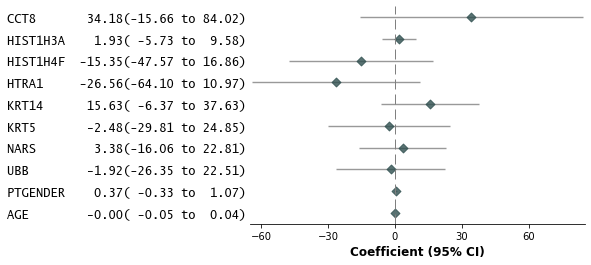

In [20]:
"""
Forest plot of risk factor coefficients
"""
import matplotlib.pyplot as plt
import forestplot as fp

fp.forestplot(
    dataframe=df_model,  # the dataframe with results data
    estimate="coef",  # col containing estimated effect size 
    ll="coef lower 95%",
    hl="coef upper 95%",
    varlabel="covariate",  # column containing variable label
    xlabel="Coefficient (95% CI)",  # x-label title
    **{
        'figsize': (6, 4),
        'xlim': (-65, 85),
        'marker': 'D',
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
        "xlinecolor": "#808080",  # gray color for x-reference line
    },
)

#plt.savefig("./output/forest_plot_methylation.png", dpi=300, bbox_inches="tight")

In [21]:
"""
Risk score calculation
"""
values = df_patients.drop(['EVENT', 'DAYS'], axis=1)
coefs = df_model['coef'].to_numpy()
df_patients['pred'] = values.dot(coefs)

df_patients['pred'].describe()
#df_patients['pred']

count    104.000000
mean      -0.880482
std        0.513949
min       -3.808864
25%       -1.141346
50%       -0.845600
75%       -0.576779
max        0.250002
Name: pred, dtype: float64

median:		-0.8456004742740335
less than:	52
equal to:	0
greater than:	52


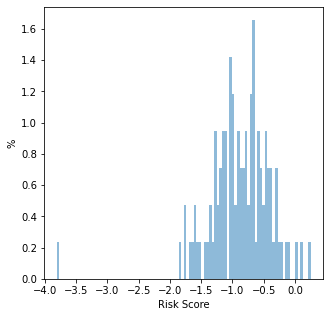

In [22]:
# Quantify risk group distribution
median = df_patients['pred'].median()
print(f"median:\t\t{median}")
print(f"less than:\t{df_patients[df_patients['pred']<median].index.size}")
print(f"equal to:\t{df_patients[df_patients['pred']==median].index.size}")
print(f"greater than:\t{df_patients[df_patients['pred']>median].index.size}")

# Visualize risk group distribution
import statsmodels.api as sm
import matplotlib.pylab as py
import matplotlib.pyplot as plt

kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
fig = plt.figure(figsize=(5,5))
plt.hist(df_patients['pred'].astype('float'), **kwargs)

plt.gca().set(ylabel='%', xlabel='Risk Score')
#plt.savefig('gene_expr_dist.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [23]:
# Set risk groups
df_patients.loc[df_patients['pred'] < median, 'risk'] = 'Low Risk'
df_patients.loc[df_patients['pred'] >= median, 'risk'] = 'High Risk'

In [24]:
# Logrank test
from lifelines.statistics import logrank_test

ix = df_patients['risk'] == 'Low Risk'
T_exp, E_exp = df_patients.loc[ix, 'DAYS'], df_patients.loc[ix, 'EVENT']
T_con, E_con = df_patients.loc[~ix, 'DAYS'], df_patients.loc[~ix, 'EVENT']

results = logrank_test(T_exp, T_con, event_observed_A=E_exp, event_observed_B=E_con)
print(results.p_value)
print(results.test_statistic)
results.print_summary()

0.013517742996209663
6.1000581971968675


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.10 0.01      6.21

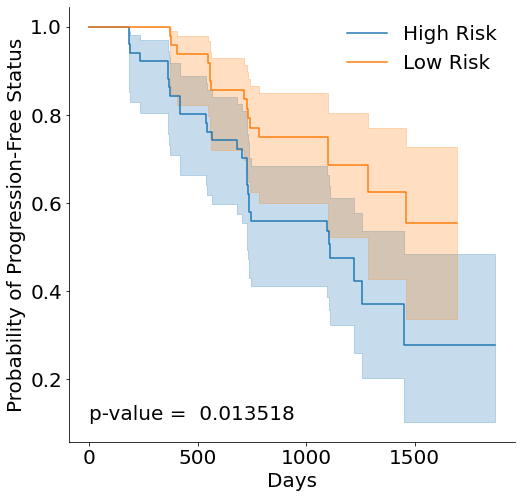

In [25]:
"""
Kaplan-Meier Plot
"""
# Kaplan-Meier time-to-event analysis
from lifelines import KaplanMeierFitter

# Plot configuration
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["font.size"] = "20"

ax = plt.subplot(111)
kmf = KaplanMeierFitter()

for name, grouped_df in df_patients.groupby('risk'):
    kmf.fit(grouped_df["DAYS"], grouped_df["EVENT"], label=name)
    kmf.plot_survival_function(ax=ax)

# Adjust plt
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(frameon=False)

ax.set_xlabel("Days")
ax.set_ylabel("Probability of Progression-Free Status")

ax.text(0, 0.1, f"p-value = {results.p_value: .6f}",
        horizontalalignment="left",
        verticalalignment="bottom")

plt.show()

# Print to PNG file
#ax.get_figure().savefig(OUTPUT_DIR / 'km_plot_methylation.png', bbox_inches='tight', dpi=300)